In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import time
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset, Subset, DistributedSampler
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import subprocess
import torch.multiprocessing as mp
import torch.optim as optim
import torch.distributed as dist
from multiprocessing import Manager
from joblib import Parallel, delayed

In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
train_set = torchvision.datasets.ImageFolder(root='Food Classification dataset/train', transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

def get_data_loader(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_set = datasets.ImageFolder(root='Food Classification dataset/train', transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    return train_loader

def train_process(rank, model, train_loader, criterion, optimizer, device, results):
    torch.set_num_threads(1)  # Limit the number of threads to reduce overhead
    model.to(device)
    total_correct = 0
    total_images = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)

    accuracy = total_correct / total_images
    results[rank] = accuracy

def train_parallel(num_workers):
    num_epochs = 2
    batch_size = 32
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = get_data_loader(batch_size=batch_size)

    dataset_size = len(train_loader.dataset)
    indices = list(range(dataset_size))
    split = dataset_size // num_workers
    subsets = [indices[i * split: (i + 1) * split] for i in range(num_workers)]
    loaders = [DataLoader(Subset(train_loader.dataset, subset), batch_size=batch_size, shuffle=True) for subset in subsets]

    manager = Manager()
    results = manager.dict()

    processes = []
    start_time = time.time()
    for rank in range(num_workers):
        device = torch.device('cpu')
        p = mp.Process(target=train_process, args=(rank, model, loaders[rank], criterion, optimizer, device, results))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
    time_taken = time.time() - start_time
    average_accuracy = sum(results.values()) / num_workers

    return time_taken, average_accuracy

def main():
    worker_configs = [1, 2, 4, 8, 16]
    training_times = []
    accuracies = []
    for workers in worker_configs:
        print(f"Training with {workers} processes...")
        time_taken, accuracy = train_parallel(workers)
        training_times.append(time_taken)
        accuracies.append(accuracy)
        print(f"Training completed in {time_taken:.2f} seconds with accuracy {accuracy*100:.2f}% using {workers} processes.")

    base_time = training_times[0]
    speedups = [base_time / time for time in training_times]
    efficiencies = [speedup / workers for speedup, workers in zip(speedups, worker_configs)]

    plot_training_times(worker_configs, training_times, accuracies, speedups, efficiencies)

def plot_training_times(worker_configs, training_times, accuracies, speedups, efficiencies):
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(worker_configs, training_times, marker='o')
    plt.title('Training Time vs. Number of Workers')
    plt.xlabel('Number of Workers')
    plt.ylabel('Training Time (seconds)')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(worker_configs, accuracies, marker='o')
    plt.title('Accuracy vs. Number of Workers')
    plt.xlabel('Number of Workers')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(worker_configs, speedups, marker='o')
    plt.title('Speedup vs. Number of Workers')
    plt.xlabel('Number of Workers')
    plt.ylabel('Speedup')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(worker_configs, efficiencies, marker='o')
    plt.title('Efficiency vs. Number of Workers')
    plt.xlabel('Number of Workers')
    plt.ylabel('Efficiency')
    

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if mp.get_start_method(allow_none=True) is None:
        mp.set_start_method('spawn')
    main()

Training with 1 processes...


KeyboardInterrupt: 

Training with 1 workers...


/home/lahoti.sh/.local/lib/python3.8/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training completed in 241.02 seconds with accuracy 99.83% using 1 workers.
Training with 2 workers...
Training completed in 169.13 seconds with accuracy 99.77% using 2 workers.
Training with 4 workers...
Training completed in 93.48 seconds with accuracy 99.37% using 4 workers.
Training with 8 workers...
Training completed in 46.72 seconds with accuracy 98.64% using 8 workers.
Training with 16 workers...
Training completed in 26.92 seconds with accuracy 97.43% using 16 workers.


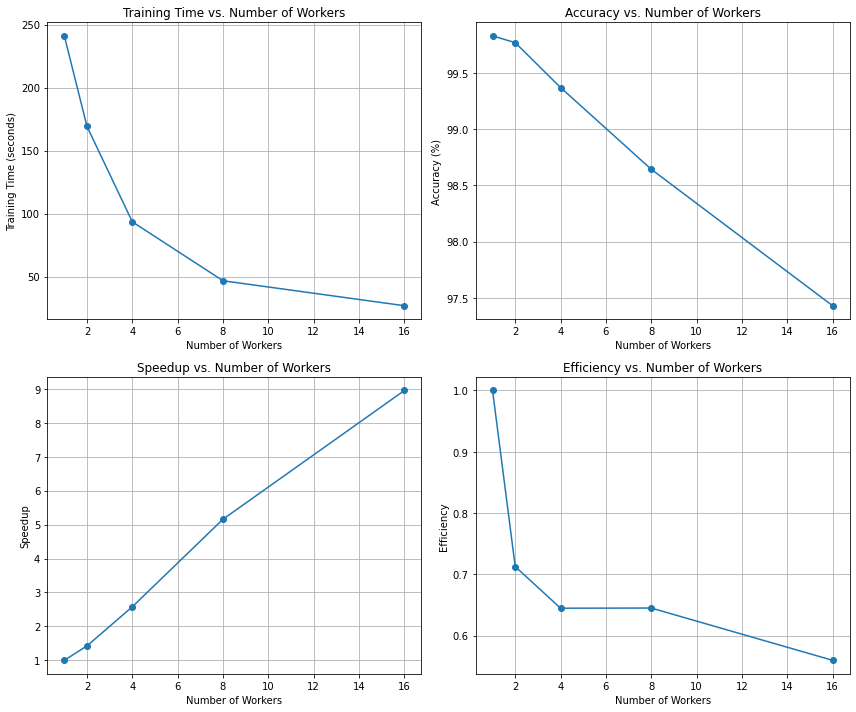

In [6]:
#using JobLib
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

def get_data_loader(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_set = datasets.ImageFolder(root='Food Classification dataset/train', transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    return train_loader

def train_process(rank, model, train_loader, criterion, optimizer, device):
    torch.set_num_threads(1)
    model.to(device)
    total_correct = 0
    total_images = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)

    accuracy = total_correct / total_images
    return accuracy

def train_parallel(num_workers):
    batch_size = 32
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = get_data_loader(batch_size=batch_size)

    dataset_size = len(train_loader.dataset)
    indices = list(range(dataset_size))
    split = dataset_size // num_workers
    subsets = [indices[i * split: (i + 1) * split] for i in range(num_workers)]
    loaders = [DataLoader(Subset(train_loader.dataset, subset), batch_size=batch_size, shuffle=True) for subset in subsets]

    start_time = time.time()
    results = Parallel(n_jobs=num_workers)(delayed(train_process)(i, model, loaders[i], criterion, optimizer, torch.device('cpu')) for i in range(num_workers))
    time_taken = time.time() - start_time
    average_accuracy = sum(results) / num_workers

    return time_taken, average_accuracy

def main():
    worker_configs = [1, 2, 4, 8, 16]
    training_times = []
    accuracies = []
    for workers in worker_configs:
        print(f"Training with {workers} workers...")
        start_time = time.time()
        time_taken, accuracy = train_parallel(workers)
        training_times.append(time_taken)
        accuracies.append(accuracy)
        print(f"Training completed in {time_taken:.2f} seconds with accuracy {accuracy * 100:.2f}% using {workers} workers.")

    # Calculate speedups and efficiencies
    base_time = training_times[0]
    speedups = [base_time / time for time in training_times]
    efficiencies = [speedup / workers for speedup, workers in zip(speedups, worker_configs)]

    # Plot the metrics
    plot_training_times(worker_configs, training_times, accuracies, speedups, efficiencies)

def plot_training_times(worker_configs, training_times, accuracies, speedups, efficiencies):
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(worker_configs, training_times, marker='o')
    plt.title('Training Time vs. Number of Workers')
    plt.xlabel('Number of Workers')
    plt.ylabel('Training Time (seconds)')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(worker_configs, [acc * 100 for acc in accuracies], marker='o')
    plt.title('Accuracy vs. Number of Workers')
    plt.xlabel('Number of Workers')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(worker_configs, speedups, marker='o')
    plt.title('Speedup vs. Number of Workers')
    plt.xlabel('Number of Workers')
    plt.ylabel('Speedup')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(worker_configs, efficiencies, marker='o')
    plt.title('Efficiency vs. Number of Workers')
    plt.xlabel('Number of Workers')
    plt.ylabel('Efficiency')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()